# TAOS1 campaign: clean ctd data

- taos1-drifters0 processed
- no ctd collected during taos1-drifters1

In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import cmocean.cm as cm

import numpy as np
import pandas as pd
import xarray as xr

#
import pynsitu as pin
from pynsitu.maps import crs
import taos.sensors as se

/Users/aponte/.miniconda3/envs/pynsitu/lib/python3.10/site-packages/pyTMD/tools.py:55: UserWarning: ipyleaflet not available
  warnings.warn("ipyleaflet not available")
/Users/aponte/.miniconda3/envs/pynsitu/lib/python3.10/site-packages/pyTMD/tools.py:56: UserWarning: Some functions will throw an exception if called
  warnings.warn("Some functions will throw an exception if called")


In [4]:
## taos
root_dir = "/Users/aponte/Current_Projects/taos/campagnes/taos1/"

# taos1-drifters0
campaign="taos1_drifters0"
yaml = f"drifters0/{campaign}.yaml"

# taos0-drifters1
#campaign="taos0_drifters1"
#yaml = f"drifters1/{campaign}.yaml"

cp = pin.Campaign(os.path.join(root_dir,yaml))

# plot all deployments
for label, deployment, platform, sensor, meta in cp.get_all_deployments():
    print(label, platform, sensor, deployment)

d0 drifter0 None d0 / start 2022-05-11 05:10:00 -0.24 49.34 / end 2022-05-13 07:10:00 -0.01 49.36
d0 drifter1 None d0 / start 2022-05-11 05:40:00 -0.25 49.33 / end 2022-05-13 07:20:00 -0.04 49.35
d0 drifter2 None d0 / start 2022-05-11 05:50:00 -0.24 49.34 / end 2022-05-13 07:30:00 -0.04 49.35
d0 hydrophone None d0 / start 2022-11-14 10:34:00 / end 2022-11-14 15:12:00
cast0 hydrophone ctd cast0 / start 2022-11-14 12:34:50 -0.24 49.34 / end 2022-11-14 12:36:00 -0.24 49.34
cast1 hydrophone ctd cast1 / start 2022-11-14 12:43:45 -0.26 49.35 / end 2022-11-14 12:45:15 -0.26 49.35
cast2 hydrophone ctd cast2 / start 2022-11-14 12:53:59 -0.27 49.33 / end 2022-11-14 12:56:11 -0.27 49.33
d0 delphy None d0 / start 2022-11-14 10:34:00 / end 2022-11-14 15:12:00
cast0 delphy ctd cast0 / start 2022-11-14 14:20:50 -0.39 49.43 / end 2022-11-14 14:23:43 -0.39 49.43
cast1 delphy ctd cast1 / start 2022-11-14 14:46:30 -0.35 49.38 / end 2022-11-14 14:50:58 -0.35 49.38
cast2 delphy ctd cast2 / start 2022-11-14

---

## ctd, underway, cast

Very convenient the GPS logging !

**taos1 - drifters0**

- Delphy, cast 1 and 2: profiles have been started too quickly: you need to wait at least 1 min at the surface

**taos1 - drifters1**

- First day - hydrophone: 
    - no gps position during half of first cast: ctd turned on too late?
    - takes about 45s for the conductivity to reach equilibrium, several downcast did not wait long enough
   
Keep only downcast (because slower than upcast) for CTD profiless


- campagne-Benji TAOS-novembre-2022-debut13h34.csv
- campagne-Benji TAOS-novembre-2022-debut13h46.csv
- campagne-Benji TAOS-novembre-2022-debut16h35.csv
- campagne-frank TAOS-novembre-2022-debut15h25.csv
- campagne-frank TAOS-novembre-2022-debut15h55.csv
- campagne-frank TAOS-novembre-2022-debut16h22.csv

In [36]:
p, s, stype = "delphy", "ctd", 0 # franck / 3 labels deployments checked
p, s, stype = "hydrophone", "ctd", 1 # benji / 3 labels deployments checked
tz_offset=-1
despike=False

# 
labels = [f"cast{i}" for i in range(3)]

label = labels[2]
print(f"label = {label}")
ctd_path = os.path.join(cp["path_raw"], f"ctd_{p}_{label}.csv")
#

label = cast2


In [37]:
df = se.read_lern_sonde(ctd_path, tz_offset=tz_offset, stype=stype)
print(f" processing "+ctd_path)

# rule=None -> raw data
df.sw.plot_bokeh(deployments=cp[p][s][label], cross=False)

 processing /Users/aponte/Current_projects/taos/campagnes/taos1/drifters0/raw/ctd_hydrophone_cast2.csv
some values of longitude and latitudes are NaN, you may want to fill in with correct values


Loading BokehJS ...

### plot raw salinity and diff to identify spikes

May be skipped if data is known not to have noisy salinity

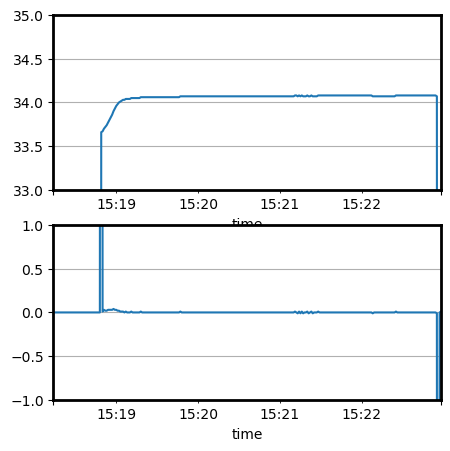

In [11]:
def plot_salinity(df, **kwargs):

    fig, axes = plt.subplots(2,1, figsize=(5,5))
    ax = axes[0]
    df.salinity.plot(ax=ax, **kwargs)
    ax.grid()
    ax.set_ylim([33,35])

    ax = axes[1]
    df.salinity.diff().plot(ax=ax, **kwargs)
    ax.grid()
    ax.set_ylim([-1,1])

plot_salinity(df)

fractions of salinity difference (with smoothed salinity) lower than 0.2 psu = 97.2%


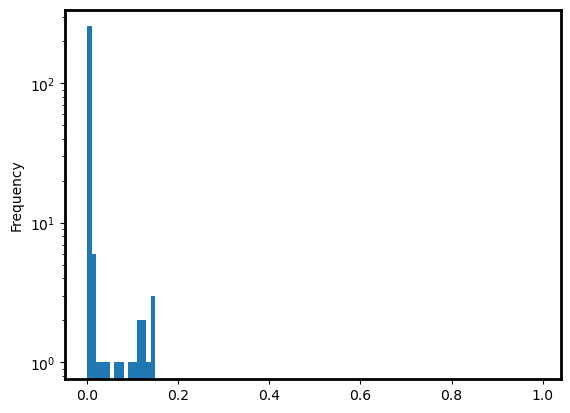

In [12]:
# salinity smoothing
rule = "10s" # 20s at 2m/s is 40m
dsalinity_threshold = 0.2

fig, ax = plt.subplots(1,1)
dfs = df.rolling(window=rule).median()
ds = df.salinity-dfs.salinity
np.abs(ds).plot.hist(bins=np.arange(0,1,.01), ax=ax)
ax.set_yscale("log")

_frac = (ds.loc[np.abs(ds)<dsalinity_threshold].index.size / ds.index.size)
print(f"fractions of salinity difference (with smoothed salinity) lower than {dsalinity_threshold} psu = {_frac*100:.1f}%")

### plot one cast time series

Search to highlight casts quality

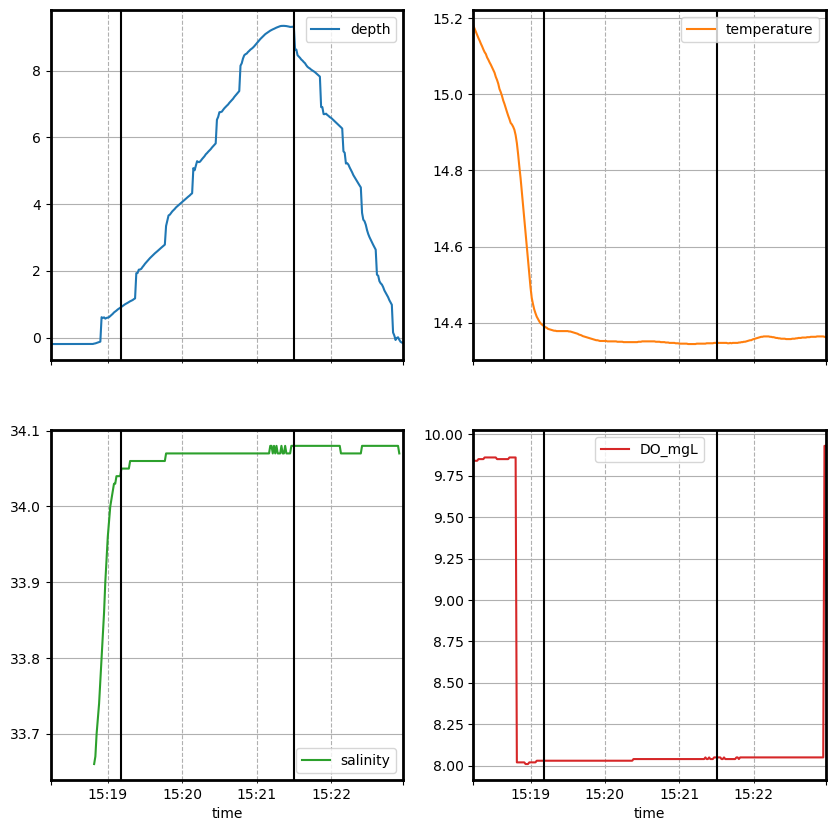

In [13]:
#_df = df.loc["2022-05-17 08:50:00":"2022-05-17 08:55:00"]
#_df = df.loc[d.start.time:d.end.time]
_df = df
d = cp[p][s][label]

_df = _df.loc[:,["depth", "temperature", "salinity", "DO_mgL"]]
_df["salinity"] = _df["salinity"].where(_df["salinity"]>30)

axes = _df.plot(subplots=True, figsize=(10,10), grid=True, layout=(2,2))
for ax in axes.flatten():
    ax.grid(which='minor', axis='both', linestyle='--')
    ax.axvline(d.start.time, color="k")
    ax.axvline(d.end.time, color="k")

---

## trim, filter and store: single file

!! This is not relevant to TAOS0-drifters0

In [ ]:
# transect parameters
ds = 20. # m, horizontal spacing - underway
vmin = 0.5 # m/s, tune search parameter - underway
dz = 0.5 # m, vertical spacing - cast

s_vars = ["salinity", "conductivity", "SA"]

if False:

    D = {}
    for label, d in cp[p][s].items():
        if (isinstance(labels, str) and labels=="all") or d.label in labels:
            # trim first to exclude irrelevant values
            _df = df.ts.trim(d)
            if d.label[0]=="u":
                # underway data
                print(d, "underway processing")
                ## simple temporal average
                #_df = _df.sw.resample("20s", op="median")
                ## despike salinity
                if despike:
                    #_df = _df.loc[ np.abs(_df.salinity.diff())<0.1 ]
                    _dfs = _df.rolling(window=rule).median() 
                    _ds = _df.salinity - _dfs.salinity
                    _df.loc[np.abs(_ds) > dsalinity_threshold, s_vars] = np.NaN
                    # interpolate gaps
                    _df.loc[:, s_vars] = _df.loc[:, s_vars].interpolate(method="linear")
                ## interpolate on a regularly sampled transect
                _df = _df.geo.compute_transect(ds, vmin=vmin)
                # update temperature, salinity and sigma0 from PA, CT
                _df = _df.sw.update_eos()
            elif d.label[0]=="c":
                print(d, "cast processing")
                # if no longitude/latitude fills with cp information
                if all(pd.isna(_df["latitude"])) or all(pd.isna(_df["latitude"])):
                    print("no values of lon/lat, fills in with cp")
                    _df["latitude"]=d.start.lat
                    _df["longitude"]=d.start.lon
                _df = _df.sw.compute_vertical_profile(dz)
                _df = _df.sw.update_eos()
            D[d.label] = _df
        else:
            print(f"skipping {d.label}")

---

## trim, filter and store: multiple files

In [38]:
# transect parameters
ds = 20. # m, horizontal spacing - underway
vmin = 0.5 # m/s, tune search parameter - underway
dz = 0.5 # m, vertical spacing - cast

s_vars = ["salinity", "conductivity", "SA"]

D = {}
for label, d in cp[p][s].items():
    ctd_path = os.path.join(cp["path_raw"], f"{s}_{p}_{d.label}.csv")
    df = se.read_lern_sonde(ctd_path, tz_offset=tz_offset, stype=stype)
    # trim first to exclude irrelevant values
    _df = df.ts.trim(d)
    if d.label[0]=="u":
        # underway data
        print(d, "underway processing")
        ## simple temporal average
        #_df = _df.sw.resample("20s", op="median")
        ## despike salinity
        if despike:
            #_df = _df.loc[ np.abs(_df.salinity.diff())<0.1 ]
            _dfs = _df.rolling(window=rule).median() 
            _ds = _df.salinity - _dfs.salinity
            _df.loc[np.abs(_ds) > dsalinity_threshold, s_vars] = np.NaN
            # interpolate gaps
            _df.loc[:, s_vars] = _df.loc[:, s_vars].interpolate(method="linear")
        ## interpolate on a regularly sampled transect
        _df = _df.geo.compute_transect(ds, vmin=vmin)
        # update temperature, salinity and sigma0 from PA, CT
        _df = _df.sw.update_eos()
    elif d.label[0]=="c":
        print(d, "cast processing")
        # if no longitude/latitude fills with cp information
        if all(pd.isna(_df["latitude"])) or all(pd.isna(_df["latitude"])):
            print("no values of lon/lat, fills in with cp")
            _df["latitude"]=d.start.lat
            _df["longitude"]=d.start.lon
        _df = _df.sw.compute_vertical_profile(dz)
    D[d.label] = _df

cast0 / start 2022-11-14 12:34:50 -0.24 49.34 / end 2022-11-14 12:36:00 -0.24 49.34 cast processing
no values of lon/lat, fills in with cp
some values of longitude and latitudes are NaN, you may want to fill in with correct values
some values of longitude and latitudes are NaN, you may want to fill in with correct values
cast1 / start 2022-11-14 12:43:45 -0.26 49.35 / end 2022-11-14 12:45:15 -0.26 49.35 cast processing
some values of longitude and latitudes are NaN, you may want to fill in with correct values
some values of longitude and latitudes are NaN, you may want to fill in with correct values
cast2 / start 2022-11-14 12:53:59 -0.27 49.33 / end 2022-11-14 12:56:11 -0.27 49.33 cast processing
some values of longitude and latitudes are NaN, you may want to fill in with correct values
some values of longitude and latitudes are NaN, you may want to fill in with correct values


### store

In [39]:
for d, _df in D.items():
    _df.to_xarray().to_netcdf(os.path.join(cp["path_processed"], f'{s}_{p}_{d}.nc'), mode="w")